In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, utils


In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1p-Xzehj-bAVZ1pH4mJuUfV48Yj3Ih-6C'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_dataset.zip')

In [0]:
# !unzip 'training_dataset.zip'
%ls

adc.json                latest_training_data.csv  training_dataset.zip
latest_training_data1/  sample_data/


In [0]:
df = pd.read_csv('latest_training_data.csv')

In [0]:
df.head()

,image_id,label
0,BreastHistoTTD_1029,1
1,BreastHistoTTD_1035,1
2,BreastHistoTTD_389,1
3,BreastHistoTTD_1086,1
4,BreastHistoTTD_411,1


In [0]:
df.label.value_counts()

1    1107
0     493
Name: label, dtype: int64

In [0]:
df['image_path'] = df['image_id'].map(lambda x: os.path.join('latest_training_data1',x+'.png'))

In [0]:
df.head()

,image_id,label,image_path
0,BreastHistoTTD_1029,1,latest_training_data1/BreastHistoTTD_1029.png
1,BreastHistoTTD_1035,1,latest_training_data1/BreastHistoTTD_1035.png
2,BreastHistoTTD_389,1,latest_training_data1/BreastHistoTTD_389.png
3,BreastHistoTTD_1086,1,latest_training_data1/BreastHistoTTD_1086.png
4,BreastHistoTTD_411,1,latest_training_data1/BreastHistoTTD_411.png


In [0]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.10, random_state = 0)

In [0]:
print(df_train['label'].value_counts()) 
print(df_val['label'].value_counts())

1    999
0    441
Name: label, dtype: int64
1    108
0     52
Name: label, dtype: int64


In [0]:
# !pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [0]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
#         iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
#         iaa.Sometimes(0.1, iaa.PiecewiseAffine(scale=(0.01, 0.03))),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
#         iaa.Sometimes(0.25,
#                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
#                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
#         iaa.Sometimes(0.1, iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True))
        
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

imgaug_transforms = ImgAugTransform()

In [0]:
class GenomeDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        self.normalize = transforms.Normalize(
                         mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]
                      )
        self.toTensor = transforms.Compose([transforms.ToTensor(), self.normalize])
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        img = Image.open(self.df.iloc[idx].loc['image_path'])
        
        if self.transform:
            img = self.transform(img)
            
        img = self.toTensor(img)
            
        if self.training:    
            label = self.df.iloc[idx].loc['label']
            return img,  label
        else:
            return img

In [0]:
# normalize = transforms.Normalize(
#    mean=[0.5, 0.5, 0.5],
#    std=[0.5, 0.5, 0.5]
# )

# trans_train = transforms.Compose([
#     transforms.Resize([224,224]),
# #     transforms.Pad(64, padding_mode='reflect'),
#     transforms.RandomHorizontalFlip(),   
#     transforms.RandomVerticalFlip(),   
#     transforms.RandomRotation(20),
# #     transforms.RandomCrop(224),
#     transforms.ToTensor(),
#     normalize
# ])

trans_test = transforms.Compose([
    transforms.Resize([224,224]),
#     transforms.ToTensor(),
#     normalize
])

train_ds = GenomeDataset(df_train, transform=imgaug_transforms)
val_ds = GenomeDataset(df_val, transform=trans_test)
# test_ds = GenomeDataset(df_test, transform=trans_test, training=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
# test_dl = DataLoader(test_ds, batch_size=32, num_workers=0)

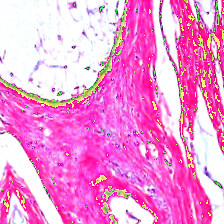

In [0]:
toPIL = transforms.ToPILImage()
toPIL(train_ds[1][0])

In [0]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         # ancestor constructor call
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
#         self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.bn5 = nn.BatchNorm2d(512)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.avg = nn.AvgPool2d(8)
#         self.fc = nn.Linear(512 * 1 * 1, 2) 
        
#     def forward(self, x):
#         x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) 
#         x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
#         x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
#         x = self.avg(x)
#         x = x.view(-1, 512 * 1 * 1) 
#         x = self.fc(x)
#         return x

In [0]:
# ## Parameters for model

# # Hyper parameters
# num_epochs = 50
# num_classes = 2
# batch_size = 32
# learning_rate = 0.001

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [0]:
def train_model(dataloders, model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
    
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc >= best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [0]:
# for name, param in list(model.named_parameters())[:42]:
#   print (name)

In [0]:
# model = SimpleCNN().to(device)

model = models.densenet161(pretrained=True)

# for param in list(model.parameters())[:117]:
#     param.requires_grad = False

for param in list(model.parameters())[:42]:
    param.requires_grad = False

num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 2)
model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 2)
        )

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
lr_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}

In [21]:
start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, scheduler=lr_cosine, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/9] train loss: 0.0001 acc: 0.9993 valid loss: 0.0003 acc: 0.9938
Epoch [1/9] train loss: 0.0001 acc: 0.9993 valid loss: 0.0009 acc: 0.9938
Epoch [2/9] train loss: 0.0001 acc: 1.0000 valid loss: 0.0006 acc: 0.9875
Epoch [3/9] train loss: 0.0006 acc: 0.9924 valid loss: 0.0005 acc: 0.9938
Epoch [4/9] train loss: 0.0005 acc: 0.9958 valid loss: 0.0003 acc: 1.0000
Epoch [5/9] train loss: 0.0005 acc: 0.9924 valid loss: 0.0013 acc: 0.9875
Epoch [6/9] train loss: 0.0001 acc: 1.0000 valid loss: 0.0009 acc: 0.9875
Epoch [7/9] train loss: 0.0000 acc: 1.0000 valid loss: 0.0005 acc: 0.9938
Epoch [8/9] train loss: 0.0000 acc: 0.9993 valid loss: 0.0006 acc: 0.9938
Epoch [9/9] train loss: 0.0000 acc: 1.0000 valid loss: 0.0007 acc: 0.9938
Best val Acc: 1.000000
Training time:   9.448325 minutes


In [0]:
model_path = os.path.join('model','densenet.pth')
# torch.save(model.state_dict(), 'densenet_99.3.pth')

In [0]:
# load model 
model.load_state_dict(torch.load(model_path))


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/genome/model/densenet_100.pth')

In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/genome/model/densenet_99.3.pth'))

In [0]:
# # Train the model
# total_step = len(train_dl)
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_dl):
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 20 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [24]:
model.eval()  
y_true=[]
y_pred=[]

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_dl:
        images = images.to(device)
#         print(images.size())
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(predicted, labels)
        correct += (predicted == labels).sum().item()
        
        y_true+=list(labels.cpu().numpy())
        y_pred+=list(predicted.cpu().numpy())
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 99.375 %


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

In [26]:
cm

array([[ 51,   1],
       [  0, 108]])

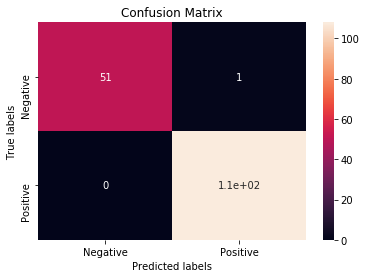

In [27]:
import seaborn as sns    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))  

0.9953917050691244
0.9908256880733946
1.0


In [0]:
# number of params
sum(p.numel() for p in model.parameters())

26693102